# 批量计算mask和img在不同的周带上面的强度以及长短径
关键函数：
count_intensity

In [6]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 对一个图像进行可视化操作

In [2]:
image = cv2.imread("SINGLE/mask.png", 0)
image.shape
image[image==255] = 1
image.max()

1

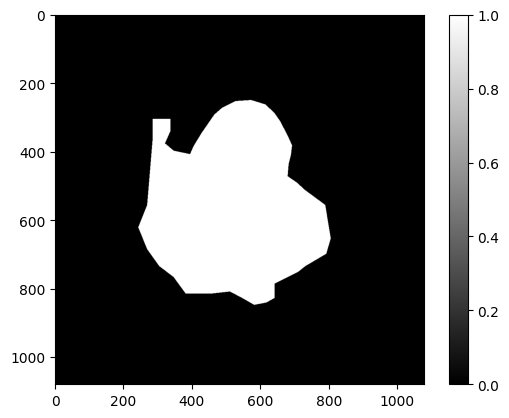

In [3]:
import matplotlib.pyplot as plt

# 使用matplotlib显示图像
plt.imshow(image, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.colorbar()
plt.show()

## 定义中心缩放函数

In [2]:
import numpy as np
# 从中心进行缩放
def resize_mask_with_center(mask, scale):
    # 计算掩膜中label的重心坐标
    label_indices = np.argwhere(mask == 1)
    center_x = np.mean(label_indices[:, 0])
    center_y = np.mean(label_indices[:, 1])

    # 创建新的掩膜并进行缩小
    new_mask = np.zeros_like(mask)
    for i, j in label_indices:
        # 将像素点的坐标减去重心坐标并乘以缩小倍数
        new_i = int((i - center_x) * scale + center_x)
        new_j = int((j - center_y) * scale + center_y)

        # 设置新掩膜对应位置处的像素值为1
        new_mask[new_i, new_j] = 1

    return new_mask



## 定义计算椭圆长短径函数

In [3]:
# 求最大的椭圆长短径, 把count_ellipse嵌入mask_123label函数！！！
def count_ellipse(binary_mask):
    # 寻找轮廓
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 初始化最大椭圆面积和对应的椭圆参数
    max_area = 0
    max_ellipse = None

    # 对每个轮廓进行椭圆拟合
    for contour in contours:
        if len(contour) >= 5:  # 至少需要5个点才能拟合椭圆
            ellipse = cv2.fitEllipse(contour)
            # 计算椭圆面积
            area = np.pi * ellipse[1][0] * ellipse[1][1]
            # 如果当前椭圆面积大于最大椭圆面积，则更新最大椭圆参数
            if area > max_area:
                max_area = area
                max_ellipse = ellipse
    return max_ellipse

##
label = 3
mask_result_label2 = np.zeros_like(mask_result)
mask_result_label2[mask_result==label] = 1


# 测试：
ellipse = count_ellipse(mask_result_label2)
# 获取椭圆信息
center_x, center_y = ellipse[0]
axis_major, axis_minor = ellipse[1]
angle = ellipse[2]

print("椭圆中心坐标：", center_x, center_y)
print("椭圆长轴和短轴长度：", axis_major, axis_minor)
print("旋转角度：", angle)

# cv2.ellipse(mask_result_label2, ellipse, (0, 0, 2), 2)  # 在图像上绘制椭圆
# plt.imshow(mask_result_label2, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
# plt.axis('on')  # 关闭坐标轴
# plt.show()

NameError: name 'mask_result' is not defined

In [4]:
# 示例使用
# original_mask = np.zeros((512, 512))
# original_mask[100:200, 200:300] = 1  # 假设这部分为label

original_mask = image

scale = 0.7  # 缩小倍数
new_mask = resize_mask_with_center(original_mask, scale)

# 使用matplotlib显示图像
plt.imshow(new_mask, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.show()

scale = 0.3  # 缩小倍数
new_mask = resize_mask_with_center(original_mask, scale)

# 使用matplotlib显示图像
plt.imshow(new_mask, cmap='gray')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.show()

NameError: name 'image' is not defined

## 定义对mask进行缩放成三个不同scale的函数

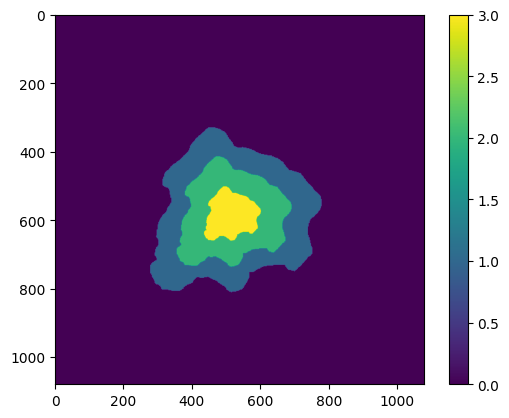

[(451.09246826171875, 496.4868469238281), (300.4902038574219, 334.3320617675781), (147.87570190429688, 163.80340576171875)]


In [7]:
def mask_123label(mask_path):
    """
    把一份掩膜分成3份,scale为1，0.7，0.3。
    """
    original_mask = cv2.imread(mask_path, 0)
    ellipse = []


    if original_mask.max() == 255:
        original_mask[original_mask == 255] = 1

    new_mask1 = np.copy(original_mask) # 需要使用deepcopy，否则new_mask与original_mask会同时变

    # 储存 长短径
    ellipse.append(count_ellipse(new_mask1)[1])

    scale = 0.67  # 缩小倍数
    new_mask2 = resize_mask_with_center(original_mask, scale)
    new_mask1[new_mask2==1] = 2
    ellipse.append(count_ellipse(new_mask2)[1])
  
    scale = 0.33  # 缩小倍数
    new_mask3 = resize_mask_with_center(original_mask, scale)
    new_mask1[new_mask3==1] = 3
    ellipse.append(count_ellipse(new_mask3)[1])

    return new_mask1, ellipse    

mask_result, ellipse = mask_123label("predict/1030-D0-2-single_B_512_mask_largest_1080/B11-B.png")

plt.imshow(mask_result, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('on')  # 关闭坐标轴
plt.colorbar()
plt.show()
print(ellipse)


## 计算荧光强度的函数

In [13]:
def count_intensity(image_path, mask_path):
    """
    mask_path为1024*1024的shape,
    image_path也一样；
    """
    # 灰度图读取image --> 使用绿色通道进行读取image
    image = cv2.imread(image_path, 1)
    image = image[:, :, 1]  # 绿色通道在OpenCV中的索引为1
    mask_result, ellipse = mask_123label(mask_path)

    # plt.imshow(image, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
    # plt.axis('off')  # 关闭坐标轴
    # plt.show()

    intensity_list = []
    for i in range(3):
        label = i + 1
        mask_ = np.zeros_like(mask_result)
        mask_[mask_result==label] = 1  # 获取环

        # plt.imshow(mask_ , cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
        # plt.axis('off')  # 关闭坐标轴
        # plt.colorbar()
        # plt.show()

        intensity = np.sum(mask_ * image) / np.sum(mask_)

        # plt.imshow(mask_ * image, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
        # plt.axis('off')  # 关闭坐标轴
        # plt.show()

        print(intensity, "maks_sum:", np.sum(mask_), "mask_max:", np.max(mask_))
        intensity_list.append(intensity)
    
    return ellipse, intensity_list

def count_intensity_for_mask(image_path, mask_path):
    # 用于计算每一份case的平均荧光强度，不分内中外三个环

    # 灰度图读取image --> 使用绿色通道进行读取image
    image = cv2.imread(image_path, 1)
    image = image[:, :, 1]  # 绿色通道在OpenCV中的索引为1
    original_mask = cv2.imread(mask_path, 0)

    print(np.sum(original_mask), np.max(original_mask), np.min(original_mask))
    print(np.sum(image), np.max(image), np.min(image))
    intensity = np.sum(original_mask * image) / np.sum(original_mask)

    # plt.imshow(original_mask * image, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
    # plt.axis('off')  # 关闭坐标轴
    # plt.show()

    # print(intensity)
    return intensity
        


ellipse, intensity_list = count_intensity("green_img/1030-D0-2-single/B2-G.png",
                                          "predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png"
                                           )

count_intensity_for_mask("green_img/1030-D0-2-single/B2-G.png",
                                          "predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png"
                                           )


68.37211458457149 maks_sum: 84130 mask_max: 1
66.1428818310995 maks_sum: 52078 mask_max: 1
53.55555555555556 maks_sum: 16902 mask_max: 1
153110 1 0
11903241 255 0


65.97825746195545

## 把不同的label在同一个img上面进行绘画

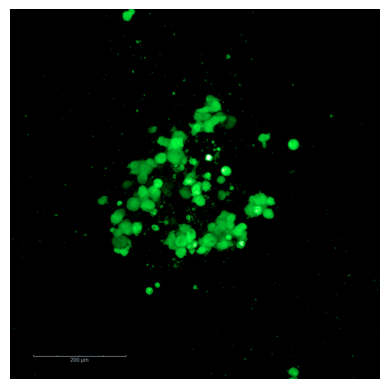

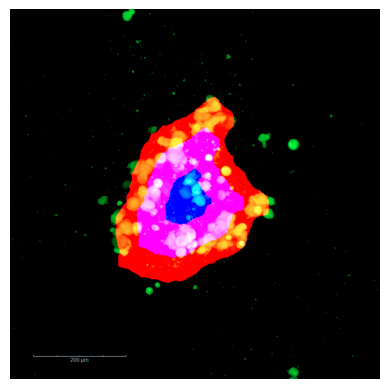

True

In [ ]:
### 单独尝试使用一个3label的mask画在img上面：
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 读取img和mask图像

img = cv2.imread('green_img/1030-D0-2-single/B2-G.png')

plt.imshow(img, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

mask, ellipse = mask_123label('predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png')

# mask = cv2.imread('predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png', 0)  # 使用灰度模式读取mask图像

# 定义颜色映射表（用于将标签转换为RGB值）
color_map = {
    0: (0, 0, 0),   # label 0 对应黑色
    1: (255, 0, 0), # label 1 对应红色
    2: (255, 0, 255), # label 2 对应绿色
    3: (0, 0, 255)  # label 3 对应蓝色
}

# 将mask图像转换为3通道，方便与img进行合并
height, width = mask.shape
mask_rgb = np.zeros((height, width, 3), dtype=np.uint8)
for label in range(4):
    mask_rgb[mask == label] = color_map[label]

# 设置半透明效果
alpha_list = [0.2, 0.4, 0.6, 0.8]  # 分别对应 label 0-3 的透明度（0-1之间）
img_with_mask = img.copy()
for label in range(4):
    alpha = alpha_list[label]
    # img_with_mask = cv2.addWeighted(img_with_mask, 1-alpha, mask_rgb, alpha, 0)
    img_with_mask = cv2.addWeighted(img_with_mask, 1, mask_rgb, alpha, 0)

# # 显示结果
# cv2.imshow('img_with_mask', img_with_mask)
# cv2.waitKey(0)

plt.imshow(img_with_mask, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.show()

# # 保存结果为png格式
cv2.imwrite('img_with_mask.png', img_with_mask)


In [ ]:
#写一个函数，批量对所有荧光的图像进行mask绘制，并保存到指定目录

def draw_mask2img(green_img_path, mask_img_path, save_draw_img_path='img_with_mask.png'):
    # 灰度图读取image --> 使用绿色通道进行读取image
    image = cv2.imread(green_img_path, 1)
    image = image[:, :, 1]  # 绿色通道在OpenCV中的索引为1
    # mask_result, ellipse = mask_123label(mask_img_path)
    img = cv2.imread(green_img_path)


    mask, ellipse = mask_123label(mask_img_path)

    # 定义颜色映射表（用于将标签转换为RGB值）
    color_map = {
        0: (0, 0, 0),   # label 0 对应黑色
        1: (255, 0, 0), # label 1 对应红色
        2: (255, 0, 255), # label 2 对应绿色
        3: (0, 0, 255)  # label 3 对应蓝色
    }

    # 将mask图像转换为3通道，方便与img进行合并
    height, width = mask.shape
    mask_rgb = np.zeros((height, width, 3), dtype=np.uint8)
    for label in range(4):
        mask_rgb[mask == label] = color_map[label]

    # 设置半透明效果
    alpha_list = [0.2, 0.4, 0.6, 0.8]  # 分别对应 label 0-3 的透明度（0-1之间）
    img_with_mask = img.copy()
    for label in range(4):
        alpha = alpha_list[label]
        # img_with_mask = cv2.addWeighted(img_with_mask, 1-alpha, mask_rgb, alpha, 0)
        img_with_mask = cv2.addWeighted(img_with_mask, 1, mask_rgb, alpha, 0)

    # 调试用，用于可视化
    # plt.imshow(img_with_mask, cmap='viridis')  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
    # plt.axis('off')  # 关闭坐标轴
    # plt.show()

    # # 保存结果为png格式
    cv2.imwrite(save_draw_img_path, img_with_mask)

draw_mask2img('green_img/1030-D0-2-single/B11-G.png',
              'predict/1030-D0-2-single_B_512_mask_largest_1080/B11-B.png')

In [ ]:
# 批量进行画图，进行可视化，把三个不同层次的mask画在green图片上面。
import os
import glob

# 需要绘制的green_img的路径
green_img_path = "green_img/1030-D0-2-single"

# 对于mask的路径
mask_img_path = "predict/1030-D0-2-single_B_512_mask_largest_1080"


green_img_files = glob.glob(os.path.join(green_img_path, '*G.png'))
green_img_files.sort()

save_path = "./draw_green_img_1030-D0-2-single"
os.makedirs(save_path, exist_ok=True)

case_name = []
big1, big2 = [], []
middle1, middle2 = [], []
small1, small2 = [], []
big_I, middle_I, small_I = [], [], []

for green_img_file in green_img_files:
    green_img_name = green_img_file.split("/")[-1]
    mask_img_file = os.path.join(mask_img_path, green_img_name.replace("G.png", "B.png"))

    save_img_path = os.path.join(save_path, green_img_file.split('/')[-1])
    print(green_img_file, mask_img_file, save_img_path)

    draw_mask2img(green_img_file, mask_img_file, save_img_path)
    

green_img/1030-D0-2-single/B11-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B11-B.png ./draw_green_img_1030-D0-2-single/B11-G.png
green_img/1030-D0-2-single/B2-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png ./draw_green_img_1030-D0-2-single/B2-G.png
green_img/1030-D0-2-single/B3-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B3-B.png ./draw_green_img_1030-D0-2-single/B3-G.png
green_img/1030-D0-2-single/B4-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B4-B.png ./draw_green_img_1030-D0-2-single/B4-G.png
green_img/1030-D0-2-single/B5-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B5-B.png ./draw_green_img_1030-D0-2-single/B5-G.png
green_img/1030-D0-2-single/B6-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B6-B.png ./draw_green_img_1030-D0-2-single/B6-G.png
green_img/1030-D0-2-single/B7-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B7-B.png ./draw_green_img_1030-D0-2-single/B7-G.png
green_img/1030-D0-2-single/B8-G.png pr

## 对比灰度读取和G读取的差异

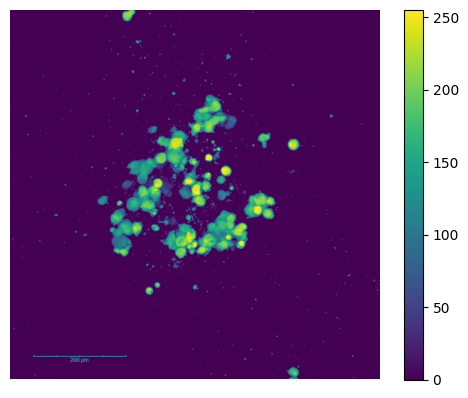

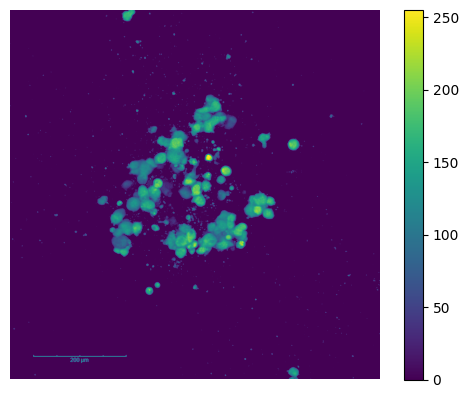

In [14]:
# 尝试使用绿色通道进行读取：
import cv2
# 以彩色图像格式读取图像
image = cv2.imread("green_img/1030-D0-2-single/B2-G.png", 1)
# 提取绿色通道
green_channel = image[:, :, 1]  # 绿色通道在OpenCV中的索引为1
plt.imshow(green_channel)  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.colorbar()
plt.show()

image = cv2.imread("green_img/1030-D0-2-single/B2-G.png", 0)

plt.imshow(image)  # cmap参数用于指定灰度图像的颜色映射，默认为'viridis'
plt.axis('off')  # 关闭坐标轴
plt.colorbar()
plt.show()

#区别有点大！！！

## 进行批量计算最后需要的内容
- ./predict文件夹下面是神经网络预测的label, *mask_largest_1080文件夹后缀的文件是最终需要用于计算的mask
- ./green_img文件夹下面是single的图

### 计算single文件夹的平均荧光强度
```python
green_img_path = "green_img/1103-D5-2-single"
mask_img_path = "predict/1103-D5-2-single_B_512_mask_largest_1080"

```


In [19]:
# 批量进行计算
import os
import glob

green_img_path = "green_img/1030-D0-2-single"
mask_img_path = "predict/1030-D0-2-single_B_512_mask_largest_1080"

green_img_files = glob.glob(os.path.join(green_img_path, '*.png'))
green_img_files.sort()

case_name = []
big1, big2 = [], []
middle1, middle2 = [], []
small1, small2 = [], []
big_I, middle_I, small_I = [], [], []

# 荧光占比
big_I_p, middle_I_p, small_I_p = [], [], []

# 平均荧光强度
mean_I = []


for green_img_file in green_img_files:
    green_img_name = green_img_file.split("/")[-1]
    mask_img_file = os.path.join(mask_img_path, green_img_name.replace("G.png", "B.png"))
    print(green_img_file, mask_img_file)
    ellipse, intensity_list = count_intensity(green_img_file,
                                          mask_img_file)
    mean_I.append(count_intensity_for_mask(green_img_file,
                                          mask_img_file))
    case_name.append(green_img_name)

    #判断大小
    if ellipse[0][0] >= ellipse[0][1]:
        big1.append(ellipse[0][0])
        big2.append(ellipse[0][1])
    else:
        big2.append(ellipse[0][0])
        big1.append(ellipse[0][1])

    if ellipse[1][0] >= ellipse[1][1]:
        middle1.append(ellipse[1][0])
        middle2.append(ellipse[1][1])
    else:
        middle2.append(ellipse[1][0])
        middle1.append(ellipse[1][1])   

    if ellipse[2][0] >= ellipse[2][1]:
        small1.append(ellipse[2][0])
        small2.append(ellipse[2][1])
    else:
        small2.append(ellipse[2][0])
        small1.append(ellipse[2][1])        


    big_I.append(intensity_list[0])
    middle_I.append(intensity_list[1])
    small_I.append(intensity_list[2])

    sum_I = intensity_list[0] + intensity_list[1] + intensity_list[2]
    big_I_p.append(intensity_list[0]/sum_I)
    middle_I_p.append(intensity_list[1]/sum_I)
    small_I_p.append(intensity_list[2]/sum_I)

    
    

green_img/1030-D0-2-single/B11-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B11-B.png
36.97909517433815 maks_sum: 88879 mask_max: 1
37.83103047051124 maks_sum: 55004 mask_max: 1
29.377530477575217 maks_sum: 17882 mask_max: 1
161765 1 0
6514229 236 0
green_img/1030-D0-2-single/B2-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B2-B.png
68.37211458457149 maks_sum: 84130 mask_max: 1
66.1428818310995 maks_sum: 52078 mask_max: 1
53.55555555555556 maks_sum: 16902 mask_max: 1
153110 1 0
11903241 255 0
green_img/1030-D0-2-single/B3-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B3-B.png
54.21391818066319 maks_sum: 94452 mask_max: 1
36.730592279669565 maks_sum: 58469 mask_max: 1
18.550174289637688 maks_sum: 18934 mask_max: 1
171855 1 0
8907543 255 0
green_img/1030-D0-2-single/B4-G.png predict/1030-D0-2-single_B_512_mask_largest_1080/B4-B.png
46.683858253077005 maks_sum: 80679 mask_max: 1
45.240146746321315 maks_sum: 49882 mask_max: 1
16.109303758471967 maks_sum: 16230 m

In [20]:

"""把数据储存成字典，再保存为csv格式"""


import pandas as pd

#create DataFrame
df = pd.DataFrame({'case':case_name,
                    '外长径': big1,
                   '外短径': big2,
                   '中长径': middle1,
                   '中短径': middle2,
                   '内长径': small1,
                   '内短径': small2,
                   '外强度': big_I,
                   '中强度': middle_I,
                   '内强度': small_I,
                   '外强度占比': big_I_p,
                   '中强度占比': middle_I_p,
                   '内强度占比': small_I_p,
                   "平均荧光强度": mean_I,
                   })

df.to_excel('./20231222#output_xlsx/1030-D0-2-single.xlsx', index=False)

In [ ]:
df = pd.read_csv('1030-D0-2-single.csv')
df.to_excel('1030-D0-2-single.xlsx', index=False)
df = pd.read_csv('1101-D3-2-single.csv')
df.to_excel('1101-D3-2-single.xlsx', index=False)
df = pd.read_csv('1103-D5-2-single.csv')
df.to_excel('1103-D5-2-single.xlsx', index=False)


In [ ]:
def threshold_binary(image_path, threshold):
    # 读取图像
    image = cv2.imread(image_path, 0)  # 以灰度模式读取图像

    # 对图像进行阈值二值化
    _, binary_image = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)

    return binary_image

### 计算all文件夹的平均荧光强度
```python
green_img_path = "20231103-ZYL-ALL/1103-D5-1-all"
mask_img_path = "20231107#ALL_binary/1103-D5-1-all-binary"
```

In [25]:
# 批量进行计算
import os
import glob

green_img_path = "20231103-ZYL-ALL/1030-D0-1-all"
mask_img_path = "20231107#ALL_binary/1030-D0-1-all-binary"

green_img_files = glob.glob(os.path.join(green_img_path, '*G.png'))
green_img_files.sort()

case_name = []
big1, big2 = [], []
middle1, middle2 = [], []
small1, small2 = [], []
big_I, middle_I, small_I = [], [], []

# 荧光占比
big_I_p, middle_I_p, small_I_p = [], [], []

# 平均荧光强度
mean_I = []

for green_img_file in green_img_files:
    green_img_name = green_img_file.split("/")[-1]
    mask_img_file = os.path.join(mask_img_path, green_img_name)
    print(green_img_file, mask_img_file)
    
    ellipse, intensity_list = count_intensity(green_img_file,
                                          mask_img_file)
    
    case_name.append(green_img_name)

    mean_I.append(count_intensity_for_mask(green_img_file,
                                          mask_img_file))

    #判断大小
    if ellipse[0][0] >= ellipse[0][1]:
        big1.append(ellipse[0][0])
        big2.append(ellipse[0][1])
    else:
        big2.append(ellipse[0][0])
        big1.append(ellipse[0][1])

    if ellipse[1][0] >= ellipse[1][1]:
        middle1.append(ellipse[1][0])
        middle2.append(ellipse[1][1])
    else:
        middle2.append(ellipse[1][0])
        middle1.append(ellipse[1][1])   

    if ellipse[2][0] >= ellipse[2][1]:
        small1.append(ellipse[2][0])
        small2.append(ellipse[2][1])
    else:
        small2.append(ellipse[2][0])
        small1.append(ellipse[2][1])        


    big_I.append(intensity_list[0])
    middle_I.append(intensity_list[1])
    small_I.append(intensity_list[2])   

    sum_I = intensity_list[0] + intensity_list[1] + intensity_list[2]
    big_I_p.append(intensity_list[0]/sum_I)
    middle_I_p.append(intensity_list[1]/sum_I)
    small_I_p.append(intensity_list[2]/sum_I)


20231103-ZYL-ALL/1030-D0-1-all/B10-G.png 20231107#ALL_binary/1030-D0-1-all-binary/B10-G.png
138.25056290379155 maks_sum: 88381 mask_max: 1
171.22325640931865 maks_sum: 54686 mask_max: 1
171.89241433724075 maks_sum: 17744 mask_max: 1
160811 1 0
26076862 255 0
20231103-ZYL-ALL/1030-D0-1-all/B11-G.png 20231107#ALL_binary/1030-D0-1-all-binary/B11-G.png
117.83300143342281 maks_sum: 103947 mask_max: 1
144.200407566424 maks_sum: 64284 mask_max: 1
156.50415750740706 maks_sum: 20926 mask_max: 1
189157 1 0
25393152 255 0
20231103-ZYL-ALL/1030-D0-1-all/B2-G.png 20231107#ALL_binary/1030-D0-1-all-binary/B2-G.png
108.32376630017899 maks_sum: 93864 mask_max: 1
135.11589980519594 maks_sum: 58007 mask_max: 1
146.58343026329703 maks_sum: 18914 mask_max: 1
170675 1 0
21292530 255 0
20231103-ZYL-ALL/1030-D0-1-all/B4-G.png 20231107#ALL_binary/1030-D0-1-all-binary/B4-G.png
104.23725836941277 maks_sum: 81995 mask_max: 1
138.22367461209362 maks_sum: 50721 mask_max: 1
171.55387225790813 maks_sum: 16502 mask_ma

In [26]:
import pandas as pd
 
#create DataFrame
df = pd.DataFrame({'case':case_name,
                    '外长径': big1,
                   '外短径': big2,
                   '中长径': middle1,
                   '中短径': middle2,
                   '内长径': small1,
                   '内短径': small2,
                   '外强度': big_I,
                   '中强度': middle_I,
                   '内强度': small_I,
                    '外强度占比': big_I_p,
                   '中强度占比': middle_I_p,
                   '内强度占比': small_I_p,
                   "平均荧光强度": mean_I,})

df.to_excel('./20231222#output_xlsx/1030-D0-1-all.xlsx', index=False)